In [1]:
import os
from astroquery.vizier import Vizier
from astropy.table import Table, join
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import numpy as np
import astropy.units as u
from astropy.io import ascii, fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['figure.figsize'] = 9, 6
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 16
rcParams['legend.fontsize'] = 'large'
rcParams['ytick.labelsize'] = rcParams['xtick.labelsize'] = 14
rcParams['figure.dpi'] = 100

## Let's take a look at our period distribution

We will be taking a look at the period distribution we get from our processing methods, and compare them to current models. Specifically [INSERT CITATION]'s model.

### [DEPRACATED] Import the Kraus & Hillenbrand (2007) Stellar SEDs Data 

This mass estimation method was depracated since the data in TIC v8 Data contains potentially more reliable data. It is still useful to see how it plays out.
I imported the Kraus & Hillenbrand (2007) Stellar SEDs Data Table that contains fitted stellar mass for low mass stars. In the following block I simply interpolate the given data to create a curve we can use to find Stellar Mass of our IC2391 targets.

Text(0, 0.5, '$M_* / M_\\odot$')

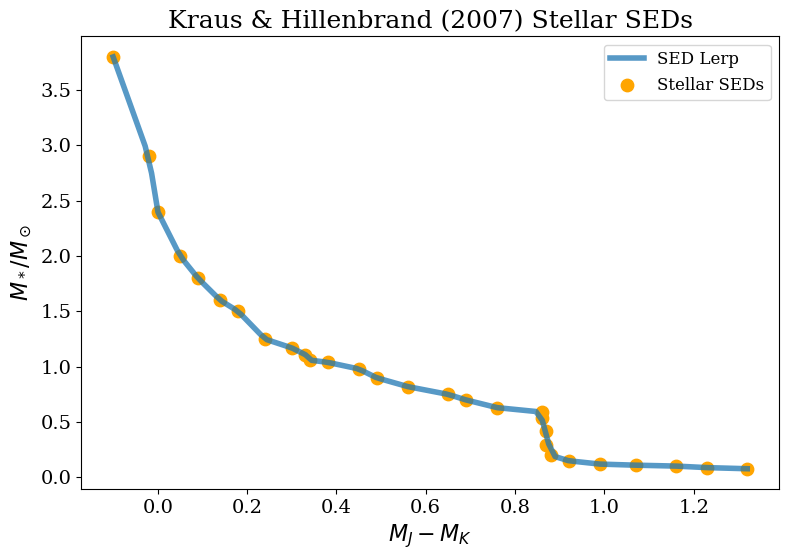

In [2]:
# Import Kraus & Hillenbrand (2007) Table 5, and Extract J-K & Masses columns 
seds_table = ascii.read('StellarModels/Kraus_2007.csv')
kraus_JK = seds_table['MJ'] - seds_table['MK']
kraus_M = seds_table['Msun']

# Create interpolate function to get the masses of any J-K values (within bounds)
KrausMass = interp1d(kraus_JK, kraus_M, kind='slinear')
KrausJK = interp1d(kraus_M, kraus_JK, kind='slinear')

jk_range = np.linspace(kraus_JK[0], kraus_JK[-1], 100)
plt.plot(jk_range, KrausMass(jk_range), lw=4, alpha=0.75, label='SED Lerp')
plt.scatter(kraus_JK, kraus_M, c='orange', alpha=1, s=80, label='Stellar SEDs')
plt.legend()
plt.title('Kraus & Hillenbrand (2007) Stellar SEDs')
plt.xlabel('$M_J - M_K$')
plt.ylabel('$M_* / M_\odot$')

## Import IC2391's Master Target Table & Add Masses targets

In [3]:
# Import master table with periods, and J-K values, then add column with Calculated Masses from Stellar SEDs
master_table = Table(fits.open('master_table.fits')[1].data)
targets = ascii.read('DataInput/cluster_targets_tic.ecsv')

kraus_masses = KrausMass(master_table['j-k'])
master_table.add_column(kraus_masses, name='Kmass')

# Join tables with all the target information
targets.rename_column('TIC ID', 'tic id')
cross_match = join(master_table, targets, keys='tic id')
targets.rename_column('tic id', 'TIC ID')

## Create index masks to get a wide and narrow Solar-like range of targets

All targets that have a meaninful period signal must lie well within the 0.1-1.25 Msun bounds because it doesn't matter which mass measurements I use, I still select the same 51 IC2391 targets.

In [4]:
# Create index mask for periods that have meaningful periodic signals, and use as filter for selection
is_period = (0.1 < cross_match['period']) & (cross_match['period'] < 28.0)
is_valid_period = (0.1 < cross_match['period']) & (cross_match['period'] < 14.0)

# Get row index mask for the master table to get WIDE Solais_periode targets
is_low_kraus = (0.1 < cross_match['Kmass']) & (cross_match['Kmass'] <= 0.75) & is_period
is_low_orig = (0.1 < cross_match['mass']) & (cross_match['mass'] <= 0.75) & is_period

# Get row index mask for the master table to get NARROW Solar-like targets
is_sun_kraus = (0.75 < cross_match['Kmass']) & (cross_match['Kmass'] < 1.25) & is_period
is_sun_orig = (0.75 < cross_match['mass']) & (cross_match['mass'] < 1.25) & is_period

# Setup numpy random seed
np.random.seed(123)

While the individual masses seem to have quite a difference between the two mass datasets, the categorized masses (is_low/is_sun) are still the same.
Further in the project we realized that using the _mass_ keyword, from TIC v8 catalog, might be more accurate so we will proceed with it.

## Import Matt's 50Myr synthetic stars

In [5]:
# The first column is the masses in Msun units?, and the second column is the period in days
m50_models = ascii.read('StellarModels/M20_30-60Myr_simple/Mattea2020_00050Myr.txt', names=['mass', 'period'])
m50UpSco_models = ascii.read('StellarModels/M20_30-60Myr_UpSco/Mattea2020_00050Myr.txt', names=['mass', 'period'])

# Create folder for saved plots
if not os.path.isdir('SyntheticComparison'):
    os.mkdir('SyntheticComparison')

# Few params
fast_period = 0.4
med_period = 6
slow_period = 8

## Plot the synthetic stars with all of IC2391's meaningful periodic signals.

Our first plot showcases our valid detected periods, periods < 14days, and 

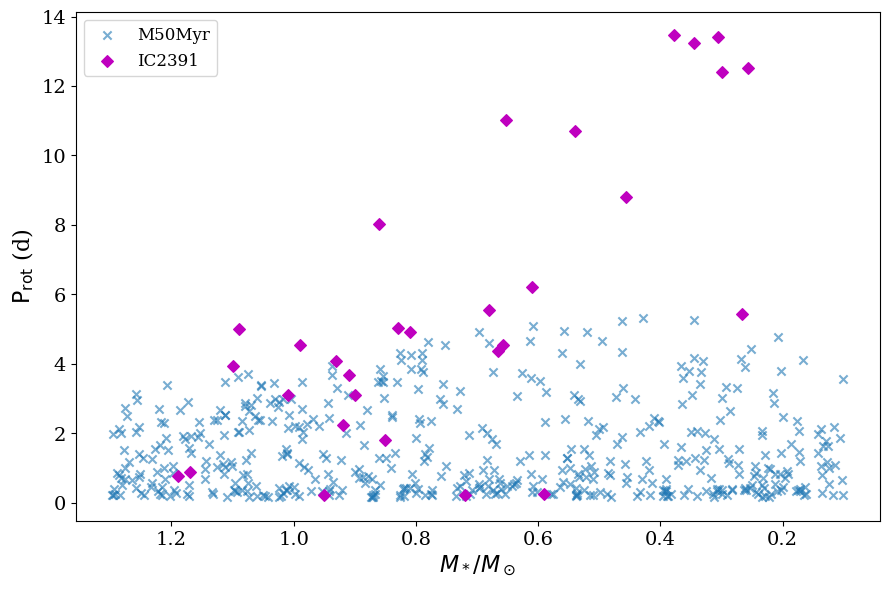

In [16]:
# Now we are ready to plot all the datasets
fig, ax = plt.subplots()

ax.scatter(m50_models['mass'], m50_models['period'], marker='x', s=35, alpha=0.6, label='M50Myr')

ax.scatter(cross_match[is_valid_period]['mass'], cross_match[is_valid_period]['period'], 
           marker='D', s=35, c='m', label='IC2391', zorder=5)

ax.set_xlabel('$M_*/M_\odot$')
ax.set_ylabel('$\mathrm{P_{rot}}$ (d)')
ax.invert_xaxis()
ax.legend(fontsize=12)
ax.set_rasterized(True)
fig.tight_layout()
plt.savefig('SyntheticComparison/valid_comp.pdf')
plt.savefig('SyntheticComparison/valid_comp.eps')

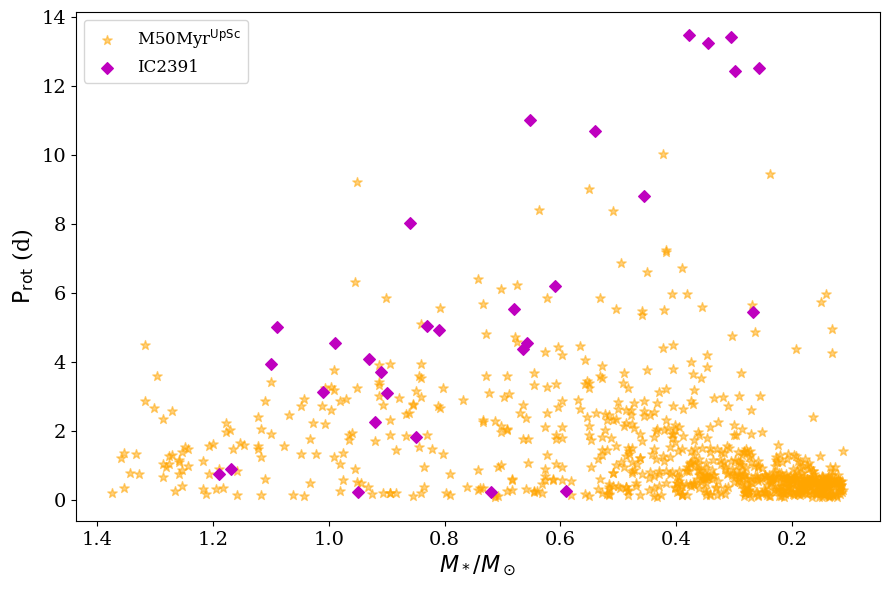

In [17]:
# Now we are ready to plot all the datasets
fig, ax = plt.subplots()

ax.scatter(m50UpSco_models['mass'], m50UpSco_models['period'], c='orange', marker='*', s=50, alpha=0.5, label='M50Myr$^{\mathrm{UpSc}}$')

ax.scatter(cross_match[is_valid_period]['mass'], cross_match[is_valid_period]['period'], 
           marker='D', s=35, c='m', label='IC2391', zorder=5)

ax.set_xlabel('$M_*/M_\odot$')
ax.set_ylabel('$\mathrm{P_{rot}}$ (d)')
ax.invert_xaxis()
ax.legend(fontsize=12)
ax.set_rasterized(True)
fig.tight_layout()
plt.savefig('SyntheticComparison/valid_comp_upsc.pdf')
plt.savefig('SyntheticComparison/valid_comp_upsc.eps')

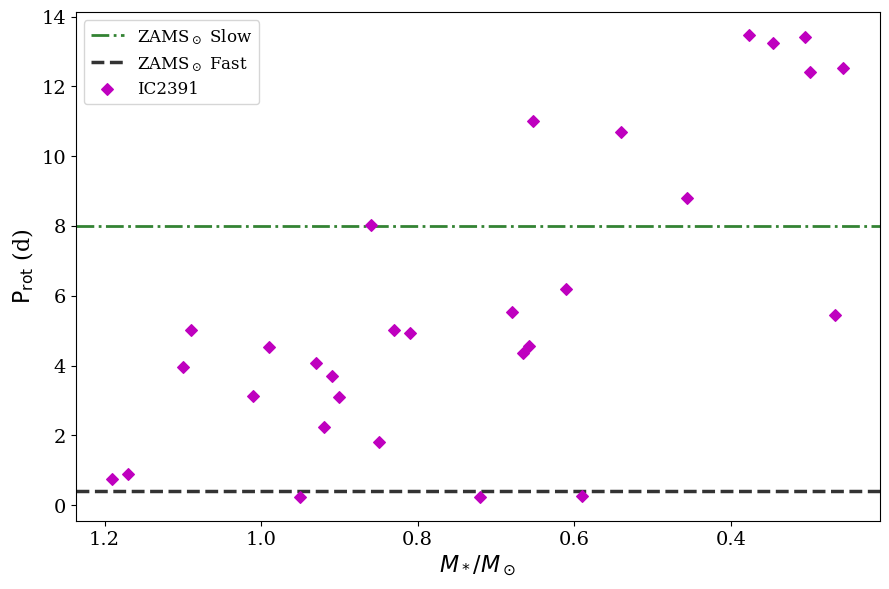

In [8]:
# Now we are ready to plot all the datasets
fig, ax = plt.subplots()

ax.scatter(cross_match[is_valid_period]['mass'], cross_match[is_valid_period]['period'], 
           marker='D', s=35, c='m', label='IC2391', zorder=5)

# Plot ZAMS relevant boundaries
# 
ax.axhline(slow_period, lw=2.0, c='darkgreen', ls='-.', alpha=0.8, label='ZAMS$_\odot$ Slow')
ax.axhline(fast_period, lw=2.5, c='k', ls='--', alpha=0.8, label='ZAMS$_\odot$ Fast')

ax.set_xlabel('$M_*/M_\odot$')
ax.set_ylabel('$\mathrm{P_{rot}}$ (d)')
ax.invert_xaxis()
ax.legend(fontsize=12)
ax.set_rasterized(True)
fig.tight_layout()
plt.savefig('SyntheticComparison/valid_ZAMS_comp.pdf')
plt.savefig('SyntheticComparison/valid_ZAMS_comp.eps')

## The following notes are a semi-structured huge dump of information regarding targets with unusually high periods.

Notes on unsually high periods:

Mean = 15.71 Mag
Median = 15.84 Mag
Max = 17.16 Mag
Min = 11.58 Mag

Most targets had a lot of noise. Some had some weird behaviors on how the lightcurve behaves due to cadence timing I think. Lots of source confusion happened due to the dim target sources. Most had a lot of noise to make anything out. Noticed trends, but nothing crazy; but the higher noise did not help.

Structure:
- Chosen Apt: Notes on chosen (best) aperture by the aperture selection automation.
- Detected period: Notes on the chosen (best) period estimate using the aforementioned aperture.
- Best Apt: Notes on the visually best lightcurve choice; e.g. difference to other apts.
- Obs period: Notes on best observed period; vetted light curves and see period.

TIC 93549226: 11 Mag target, whole lot of leaking light, can't tell how many sources
- Chosen Apt: Percentile, least trendy, not highest amplitude
- Detected period: 18.30d, doesn't exist!
- Best Apt: Threshold, highest amplitude w/ slight trend
- Obs period: ~3d, both Threshold & Percentile periodograms show second peak 

TIC 93832597: 15 Mag target, several brightness variations on cutout
- Chosen Apt: Threshold, bad choice
- Detected period: 17.55, doesn't exist
- Best Apt: Handpicked, others picked wrong source
- Obs period: ~1.7d, Must run LS on handpicked

TIC 93836787: 14 Mag target with a few neighbors
- Chosen Apt: Handpicked, only/best choice
- Detected period: 20.24d, cannot visually confirm
- Best Apt: Handpicked, others chose wrong source
- Obs period: 2.1d, no significant power in any periodogram

TIC 93912428: 14 Mag target with brighter neighbor within cutout.
- Chosen Apt: Threshold, a bad choice.
- Detected period: 17.6, defintely doesn't exist
- Best Apt: Handpicked, shows a weak/noisy signal; only correct LC.
- Obs period: ~1.5d, nothing trusty on periodograms. must run LS on handpicked.

TIC 94103916: 15 Mag target with bright neighbor at the very edge of cutout. 
- Chosen Apt: Percentile, bad choice,
- Detected period: 17.97d, doesn't exist.
- Best Apt: Handpicked, shows very weak/noise fast signal; only correct LC
- Obs period: 1/10 day, very fast, must run LS on handpicked.

TIC 94185042: 16 Mag target with couple of neighbors on edges of cutout.
- Chosen Apt: Percentile, not the worst
- Detected period: 24.57d, doesn't exist
- Best Apt: Handpicked, best by far, mixed weak/noisy signals
- Obs period: 1/10 day, and ~4d. Periodogram shows a 2nd peak on 3.7d. Nothing else. Must run LS on handpicked.

How can the aperture selection method be improved upon?
The above notes prove that Handpicked works best for these dim targets. There two things I have to say about this:
- This aperture type assumes TESS team target centering is on point; so it might be best to assume it with the other automated methods. The other methods attempt to take the centermost source, but don't assume that the target will always be at the center.
- If the last point isn't true, not all targets are well centered, then we can force an aperture method for targets within magnitude ranges. For example, it is clear that handpicked aperture works best for these dim targets, so we force it for targets with Mag > 15.
- We can also combine both points and weight the decision making in the code.

If we proceed to working with an automated method then there is an important tweek that must happen. Our current automated system will compare the noise (or coherence) of the each lightcurve created from the corresponding aperture methods. You can read more about the noise estimate in the LCQualityIndicator notebook. The problem with this is that is we solely base our seleciton on the noise, we could be selecting a signal-less ceherent lightcurve that missess the target. A way to counter this is by taking a look at the periodogram of each lightcurve. We run the Lomb-Scargle periodogram on each and weight the expected peak ranges (detected periods) such that we are chosing apertures/lightcurves with low noise AND a true/expected period. This allow us to minimize noise and maximize signal amplitude (or power), as all light curve selections should go.